In [1]:
# Install necessary libraries and version (tenforlow.org)
!pip install tensorflow-text==2.3
!pip install tensorflow==2.3.1
!pip install tf-models-official==2.3.0
!pip install -q tf-models-official==2.3

     |████████████████████████████████| 2.6MB 13.7MB/s 
     |████████████████████████████████| 320.4MB 52kB/s 
     |████████████████████████████████| 460kB 46.5MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 320.4MB 48kB/s 
  Found existing installation: tensorflow 2.3.2
    Uninstalling tensorflow-2.3.2:
      Successfully uninstalled tensorflow-2.3.2
     |████████████████████████████████| 849kB 9.8MB/s 
     |████████████████████████████████| 358kB 25.2MB/s 
     |████████████████████████████████| 1.2MB 22.2MB/s 
     |████████████████████████████████| 706kB 23.4MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 174kB 54.2MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp37-none-any.whl size=20070 sha256=f7bbd79f66ad67765c19bb4dbf21e1864838f9523e0f0420963a07a8339445cb
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [2]:
# Data processing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Text preprocessing Libraries
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Neural Network Libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [3]:
# Train and Test Data from Kaggle
train_df = pd.read_csv("/content/drive/MyDrive/Full Projects/Disaster Prediction/data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Full Projects/Disaster Prediction/data/test.csv")


In [4]:
# Len df
print(len(train_df))
train_df.head()

7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Dropping ome duplicated rows
# train_df.duplicated(subset=['brand'])
train_df = train_df.drop_duplicates('text', keep='last')
print(len(train_df))

7503


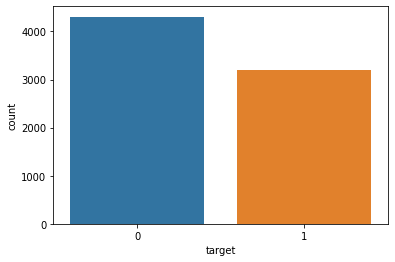

0    4307
1    3196
Name: target, dtype: int64


In [6]:
# Counting the classes (Slightly Imbalanced)
sns.countplot(x=train_df['target'])
plt.show()
print(train_df['target'].value_counts())

In [7]:
# Compute class weights 
from sklearn.utils.class_weight import compute_class_weight
labels = list(train_df['target'].unique())
weights = compute_class_weight(
           'balanced',
            train_df['target'].unique(), 
            train_df['target'])
class_weights = dict(zip(labels, weights))

In [8]:
class_weights

{0: 0.8710239145576968, 1: 1.173811013767209}

In [9]:
np.asarray(train_df['target'].value_counts(normalize=True) * 2.045)

array([1.17390577, 0.87109423])

#Text Preprocessing

In [10]:
# Regex patterns from RETech
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

URLPATTERN = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

# USERPATTERN = '@[^\s]+'

# SEQPATTERN = r"(.)\1\1+"

# SEQREPLACE = r"\1\1"

In [11]:
# Identifying patterns to use
# train_df['text'].str.contains('http').sum()
# train_df['text'].str.contains(":\)").sum()
# Accuracy dropped by removing @usernames

In [12]:
# Preprocessing function
def preprocess_text(text):
  text = re.sub(URLPATTERN, 'URL', text)
  text = text.replace("#","")
  for emoji in EMOJIS:
    text = text.replace(emoji, "EMOJI"+EMOJIS[emoji])
  return text


In [13]:
# Apply preprocessing functions
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [14]:
# Validating preprocessing
train_df['text'].sample(5)

1047    ÛÏParties and body bags go together like drin...
1249    What news reports am I missing? Are there buil...
5039             BakeOffFriends the one with the mudslide
3245    just got engulfed in a car-induced tidal wave ...
1188    Mexico: construction of bridge collapse killså...
Name: text, dtype: object

In [15]:
# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, test_size = 0.1, random_state=32)

# tweaked model using validation but removing for more training data on final run
# val_df, test_df = train_test_split(val, test_size = 0.5, random_state=32)

In [16]:
# Creating tensor dataset
batch_size = 64
seed = 32

train_ds = tf.data.Dataset.from_tensor_slices((train['text'].tolist(), train['target'].tolist())).batch(batch_size)
# val_ds = tf.data.Dataset.from_tensor_slices((val_df['text'].tolist(), val_df['target'].tolist())).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test['text'].tolist(), test['target'].tolist())).batch(batch_size)

In [17]:
# BERT text preprocessing layer
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"

# BERT Encoding layer
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3"


In [18]:
# Slightly modified version of tensorflow tutorial
def classifier_model():
  # Text encoding layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_layer')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing_layer')
  encoder_inputs = preprocessing_layer(text_input)

  # Feeding the encoded text to the BERT model
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder_layer')
  outputs = encoder(encoder_inputs)

  # Taking the pooled output 
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_layer')(net)
  return tf.keras.Model(text_input, net)

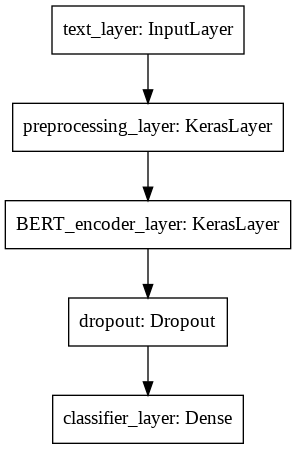

In [19]:
# plotting model achitecture
classifier_model = classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [20]:
# Setting loss and accuracy
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy() # accuracy out is based on a threshold of 0.5 will test different threshold with test set and auc_roc


In [21]:
# Setting lr warm up step parameters 
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

# Create optimizer
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [22]:
# Compiling model optimizer, loss, and accuracy metric
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [23]:
# Setting EarlyStopping callback 
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [24]:
# Confirming model is on GPU 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
# Training the model with train_df, callback, and class_weight parameters
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds.shuffle(1000), 
                               callbacks=[callback],
                               class_weight=class_weights,
                               epochs=epochs)

# validation_data= val_ds


Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/20
106/106 [==============================] - 60s 562ms/step - loss: 0.6807 - binary_accuracy: 0.6250
Epoch 2/20
106/106 [==============================] - 60s 562ms/step - loss: 0.5961 - binary_accuracy: 0.8036
Epoch 3/20
106/106 [==============================] - 59s 560ms/step - loss: 0.5825 - binary_accuracy: 0.8276
Epoch 4/20
106/106 [==============================] - 59s 558ms/step - loss: 0.5718 - binary_accuracy: 0.8510
Epoch 5/20
106/106 [==============================] - 59s 559ms/step - loss: 0.5660 - binary_accuracy: 0.8639
Epoch 6/20
106/106 [==============================] - 59s 558ms/step - loss: 0.5606 - binary_accuracy: 0.8757
Epoch 7/20
106/106 [==============================] - 59s 558ms/step - loss: 0.5565 - binary_accuracy: 0.8836
Epoch 8/20
106/106 [==============================] - 59s 559ms/step - loss: 0.5530 - binary_accuracy: 0.8916
Epoch 9/20
106/106 [===================

In [26]:
# Computing loss and accuracy on the test set
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

12/12 [==============================] - 2s 192ms/step - loss: 0.6188 - binary_accuracy: 0.8402
Loss: 0.6187986135482788
Accuracy: 0.8402130603790283


In [27]:
# Creating y_test and y_pred values for roc_auc
y_test = np.asarray(test['target'].tolist())
y_pred = classifier_model.predict(test['text'].tolist())

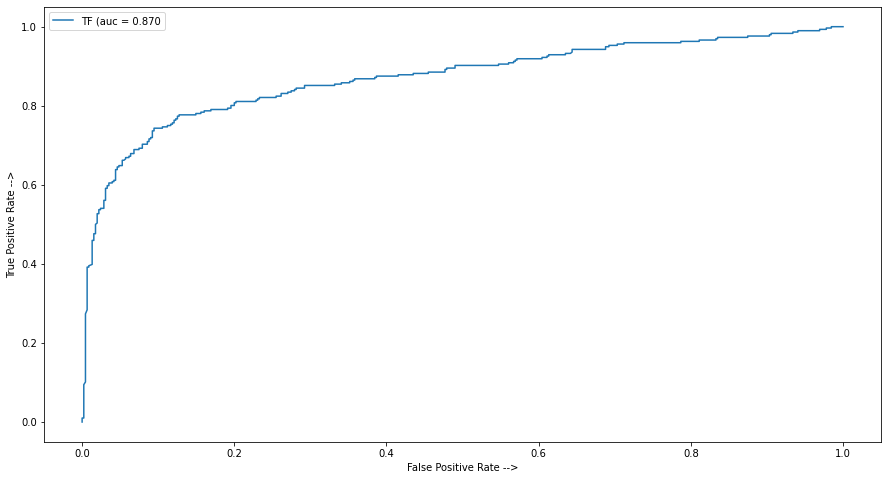

In [28]:
# Plotting roc_curve and auc threshold
from sklearn.metrics import roc_curve, auc, classification_report

pred_fpr, pred_tpr, threshold = roc_curve(y_test, y_pred)

tf_auc = auc(pred_fpr, pred_tpr)

plt.figure(figsize=(15,8))
plt.plot(pred_fpr, pred_tpr, linestyle='-', label='TF (auc = %0.3f' % tf_auc)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

In [29]:
# Final adjustments based on roc curve before classification report
final_preds = []
for s in y_pred:
  if s >= 0.5:
    final_preds.append(1)
  else:
    final_preds.append(0)

In [30]:
# Classification report 
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       455
           1       0.84      0.74      0.78       296

    accuracy                           0.84       751
   macro avg       0.84      0.82      0.83       751
weighted avg       0.84      0.84      0.84       751



In [39]:
# Save the model 
classifier_model.save('tweet_model.pb', include_optimizer=False)

INFO:tensorflow:Assets written to: tweet_model.pb/assets


INFO:tensorflow:Assets written to: tweet_model.pb/assets


In [47]:
# Reload model for inference
reloaded_model = tf.keras.models.load_model('/content/tweet_model.pb')

In [49]:
# Review architecture
reloaded_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_layer (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing_layer (KerasLayer {'input_word_ids': ( 0           text_layer[0][0]                 
__________________________________________________________________________________________________
BERT_encoder_layer (KerasLayer) {'encoder_outputs':  108310273   preprocessing_layer[0][0]        
                                                                 preprocessing_layer[0][1]        
                                                                 preprocessing_layer[0][2]        
_______________________________________________________________________________________

In [50]:
# Recompile the model
reloaded_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [57]:
# Load the kaggle test dataset
results = pd.read_csv("/content/drive/MyDrive/Full Projects/Disaster Prediction/data/test.csv")

In [71]:
# Create tensor dataset
results_ds = tf.data.Dataset.from_tensor_slices((results['text'].tolist())).batch(batch_size)

In [72]:
# Predict on the test dataset (results)
result_preds = np.round(reloaded_model.predict(results_ds),2)

In [74]:
# Final adjustments based on roc curve before classification report
final_preds = []
for s in result_preds:
  if s >= 0.5:
    final_preds.append(1)
  else:
    final_preds.append(0)

In [56]:
# Classification report 
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       455
           1       0.84      0.74      0.78       296

    accuracy                           0.84       751
   macro avg       0.84      0.82      0.83       751
weighted avg       0.84      0.84      0.84       751



In [76]:
# appending the rounded results to the df and dropping columns based on requirements
results['target'] = final_preds
results = results.drop(columns=['text', 'keyword','location'], axis=1)

In [77]:
results

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [78]:
# Save to csv for upload
results.to_csv("/content/drive/MyDrive/Full Projects/Disaster Prediction/results.csv", index=False)